In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

In [2]:
train_raw = pd.read_csv('./train_data/train_task_3_4.csv')
test_raw = pd.read_csv('./test_data/quality_response_remapped_public.csv')
final_test_raw = pd.read_csv('./test_data/quality_response_remapped_private.csv')
question_meta_raw = pd.read_csv('./metadata/question_metadata_task_3_4.csv')
student_meta_raw = pd.read_csv('./metadata/student_metadata_task_3_4.csv')
subject_meta_raw = pd.read_csv('./metadata/subject_metadata.csv')
answer_meta_raw = pd.read_csv('./metadata/answer_metadata_task_3_4.csv')

In [3]:
# main data to be trained with
train_raw.head(3)

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2


In [4]:
# private test data
final_test_raw['T4_MQ'] = final_test_raw['T4_MQ'].fillna(1)
final_test_raw = final_test_raw.drop(final_test_raw.columns[[0,1]], axis=1 )
final_test_raw = final_test_raw.astype({'T4_MQ' : 'int'})
final_test_raw.head(3)

,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,145,762,2,2,2,2,2
1,307,208,1,1,1,2,1
2,278,195,1,1,1,1,1


In [5]:
# public test data.
test_raw = test_raw.drop(test_raw.columns[[0,1]], axis=1 )
test_raw = test_raw.astype({'T4_MQ' : 'int'})
test_raw.head(3)

,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,909,318,2,2,2,1,2
1,285,609,2,2,2,2,2
2,132,271,1,2,2,2,1


In [6]:
# metadata about question. question != subject
question_meta_raw
question_meta_data = question_meta_raw.set_index('QuestionId').sort_index()
question_meta_data

,SubjectId
QuestionId,
0,"[3, 32, 40, 245]"
1,"[3, 32, 39, 228]"
2,"[3, 32, 33, 42, 144, 212]"
3,"[3, 32, 42, 211]"
4,"[3, 71, 88, 174]"
...,...
943,"[3, 32, 33, 144]"
944,"[3, 32, 37, 221]"
945,"[3, 32, 42, 212]"


In [7]:
# metadata about student. 
student_meta_data = student_meta_raw.sort_values(by = 'UserId').set_index('UserId')
# student_meta_data['DateOfBirth']
student_meta_data

,Gender,DateOfBirth,PremiumPupil
UserId,,,
0,2,2008-06-01 00:00:00.000,NaN
1,0,NaN,NaN
2,0,NaN,NaN
3,1,2008-05-01 00:00:00.000,0.0
4,0,NaN,NaN
...,...,...,...
6143,0,NaN,NaN
6144,2,NaN,NaN
6145,0,NaN,NaN


In [8]:
# metadata about subjects. it is the key database to figure out the structure of the relationship-tree. 
subject_meta_raw['ParentId'] = subject_meta_raw['ParentId'].fillna(0)
subject_meta_raw['ParentId'] = subject_meta_raw['ParentId'].astype(int)
subject_meta_data = subject_meta_raw[['SubjectId', 'ParentId', 'Level']].set_index('SubjectId')
subject_meta_data.head(3)

,ParentId,Level
SubjectId,,
3,0,0
32,3,1
33,144,3


In [9]:
# meta data about 
answer_meta_raw.head(3)

,AnswerId,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,1451945,2019-10-30 14:34:00.000,NaN,4,32,52562.0
1,45325,2020-01-06 18:53:00.000,75.0,185,66,52562.0
2,687013,2020-01-18 10:52:00.000,NaN,235,64,52562.0


In [10]:
# join the main data with the answer-meta data

# def parse_time_to_unix(date_string):
#     date_string = date_string.rstrip()[:-4]
#     date_format = "%Y-%m-%d %H:%M:%S"
#     parsed = datetime.datetime.strptime(date_string, date_format)
#     dt = datetime.datetime(parsed.year, parsed.month, parsed.day, parsed.hour, parsed.minute, parsed.second)
#     unix_time = dt.timestamp()
#     return int(unix_time)
    
main_with_answer = train_raw.join(answer_meta_raw.set_index('AnswerId'), on = 'AnswerId')
# train_with_answer['Date'] = train_with_answer['DateAnswered'].apply(parse_time_to_unix)
main_with_answer

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,898,2111,280203,1,2,2,2019-12-08 17:47:00.000,NaN,95,86,52562.0
1,767,3062,55638,1,3,3,2019-10-27 20:54:00.000,25.0,115,39,52562.0
2,165,1156,386475,1,2,2,2019-10-06 20:16:00.000,NaN,101,39,52562.0
3,490,1653,997498,1,4,4,2020-02-27 17:40:00.000,NaN,46,115,52562.0
4,298,3912,578636,1,3,3,2019-12-27 16:07:00.000,NaN,314,78,52562.0
...,...,...,...,...,...,...,...,...,...,...,...
1382722,80,2608,57945,1,2,2,2019-11-28 15:22:00.000,NaN,270,65,52562.0
1382723,707,2549,584230,0,2,1,2020-01-06 16:26:00.000,NaN,269,109,52562.0
1382724,840,5901,1138956,1,1,1,2020-01-07 07:14:00.000,NaN,270,66,52562.0
1382725,794,3854,1151183,0,1,3,2019-12-15 16:32:00.000,NaN,339,9,52562.0


In [11]:
# Confidence columns have many NAN values. about 75%. only 25% are useful. 
print(main_with_answer['Confidence'].isna().sum() / len(main_with_answer['Confidence']) * 100)

74.94603056134726


In [12]:
# main data with answer, student metadata joined 
main_answer_student = main_with_answer[main_with_answer.columns[[0,1,3,6,7]]].join(student_meta_data, on = 'UserId')
main_answer_student = main_answer_student.drop(['Gender', 'PremiumPupil'],axis=1)
print(main_answer_student['DateOfBirth'].isna().sum())
print(main_answer_student.dtypes)
main_answer_student

655382
QuestionId        int64
UserId            int64
IsCorrect         int64
DateAnswered     object
Confidence      float64
DateOfBirth      object
dtype: object


,QuestionId,UserId,IsCorrect,DateAnswered,Confidence,DateOfBirth
0,898,2111,1,2019-12-08 17:47:00.000,NaN,2007-09-01 00:00:00.000
1,767,3062,1,2019-10-27 20:54:00.000,25.0,NaN
2,165,1156,1,2019-10-06 20:16:00.000,NaN,NaN
3,490,1653,1,2020-02-27 17:40:00.000,NaN,NaN
4,298,3912,1,2019-12-27 16:07:00.000,NaN,2008-04-01 00:00:00.000
...,...,...,...,...,...,...
1382722,80,2608,1,2019-11-28 15:22:00.000,NaN,NaN
1382723,707,2549,0,2020-01-06 16:26:00.000,NaN,2007-11-01 00:00:00.000
1382724,840,5901,1,2020-01-07 07:14:00.000,NaN,NaN
1382725,794,3854,0,2019-12-15 16:32:00.000,NaN,NaN


In [13]:
# fill NaN value of DateOfBirth with the mean and extract student's age
main_answer_student['BirthYear'] = main_answer_student['DateOfBirth'].map(lambda x : x if pd.isna(x) else int(x[:4]))
main_answer_student['BirthYear'].fillna(main_answer_student['BirthYear'].mean(), inplace=True)
main_answer_student['TestYear'] = main_answer_student['DateAnswered'].map(lambda x : int(x[:4]))
main_answer_student['Age'] = main_answer_student['TestYear'] - main_answer_student['BirthYear']
main_answer_student['Age'] = main_answer_student['Age'].apply(int)
main_answer_student

,QuestionId,UserId,IsCorrect,DateAnswered,Confidence,DateOfBirth,BirthYear,TestYear,Age
0,898,2111,1,2019-12-08 17:47:00.000,NaN,2007-09-01 00:00:00.000,2007.000000,2019,12
1,767,3062,1,2019-10-27 20:54:00.000,25.0,NaN,2007.630089,2019,11
2,165,1156,1,2019-10-06 20:16:00.000,NaN,NaN,2007.630089,2019,11
3,490,1653,1,2020-02-27 17:40:00.000,NaN,NaN,2007.630089,2020,12
4,298,3912,1,2019-12-27 16:07:00.000,NaN,2008-04-01 00:00:00.000,2008.000000,2019,11
...,...,...,...,...,...,...,...,...,...
1382722,80,2608,1,2019-11-28 15:22:00.000,NaN,NaN,2007.630089,2019,11
1382723,707,2549,0,2020-01-06 16:26:00.000,NaN,2007-11-01 00:00:00.000,2007.000000,2020,13
1382724,840,5901,1,2020-01-07 07:14:00.000,NaN,NaN,2007.630089,2020,12
1382725,794,3854,0,2019-12-15 16:32:00.000,NaN,NaN,2007.630089,2019,11


In [14]:
# final data and fill NaN value with the mean...
final_data = main_answer_student.drop(['DateAnswered', 'DateOfBirth', 'BirthYear', 'TestYear'], axis =1)
print(final_data.isna().sum())
final_data_test = final_data
final_data = final_data.fillna(final_data['Confidence'].mean())
# final_data = final_data.dropna()


QuestionId          0
UserId              0
IsCorrect           0
Confidence    1036299
Age                 0
dtype: int64


In [15]:
# TEST for DROP NAN case

# # final_data_test =final_data_test.dropna().drop('UserId', axis =1).set_index('QuestionId')
# X = final_data_test.groupby('QuestionId').mean()
# # using unspervised learning with two categories
# # kmeans = KMeans(n_clusters=2)
# # kmeans.fit(X)
# #prediction
# # y_pred = kmeans.predict(X)
# # plt.hist(y_pred)
# #the how close the data is beloinging to each assigned group.
# # since we have two opposite groups the probability of one group should be reversed. 
# score_val = silhouette_samples(X, kmeans.labels_)
# score_val[y_pred == 1] = -score_val[y_pred == 1]
# score_val
# # sort by score value
# X['score'] = score_val
# X = X.sort_values('score')
# X
# sns.scatterplot(data = X, x = 'Confidence', y='score')

In [16]:
#group by questionId 
final_data= final_data.groupby('QuestionId').mean()
final_data

,UserId,IsCorrect,Confidence,Age
QuestionId,,,,
0,3063.576102,0.443457,71.128780,11.310811
1,3655.928571,0.571429,73.947617,12.857143
2,3013.855166,0.385214,71.968351,11.358841
3,3029.721931,0.808757,76.873508,11.348054
4,3028.669601,0.401408,71.402170,12.154930
...,...,...,...,...
943,3050.533735,0.566528,77.239537,11.283076
944,3192.772487,0.142857,73.211009,12.105820
945,3011.370988,0.422336,73.498032,11.349166


In [17]:
# Opacity level indicates how scattered the subject topic is... 
# It is decided with the number of the leaf nodes of the tree...
# the more leaf nodes mean the more dispersed the topic is. whichi is against the golden rule to be a good question.

tot = len(question_meta_data)
opacity_level = np.zeros(tot) - 1


def how_many_leaf(tree_list):
    tree_nodes = [(k, subject_meta_data['ParentId'].loc[k]) for k in tree_list]
    possible_leaves = {}
    for cur, par in tree_nodes:
        if cur not in possible_leaves or par == 0:
            possible_leaves[cur] = {}
        if par in possible_leaves:
            del possible_leaves[par]
    return len(possible_leaves)
       
opacity_level = []
for i in range(tot):
    tree_list = list(map(int,question_meta_data.iloc[i].tolist()[0].replace('[', ',').replace(']', ',').split(',')[1:-1]))
    n_leaf = how_many_leaf(tree_list)
    opacity_level.append(n_leaf)

In [18]:
final_data['Opacity'] = opacity_level
final_data = final_data.drop('UserId', axis =1)
final_data_original = final_data.copy()

In [19]:
X = final_data.copy()

In [20]:
#using unspervised learning with two categories
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

(array([337.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 611.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

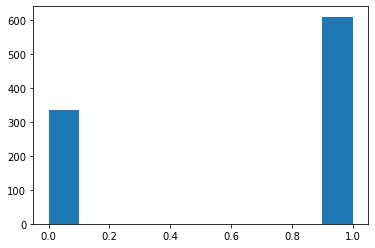

In [21]:
#prediction
y_pred = kmeans.predict(X)
plt.hist(y_pred)

In [22]:
#the how close the data is beloinging to each assigned group.
# since we have two opposite groups the probability of one group should be reversed. 

score_val = silhouette_samples(X, kmeans.labels_)
score_val[y_pred == 1] = -score_val[y_pred == 1]
score_val

array([ 0.55511682, -0.30375531,  0.38422418, -0.57830943,  0.53984937,
       -0.44147897, -0.62231191,  0.55737876,  0.43341388, -0.39721602,
        0.55839078,  0.53965092, -0.53027512, -0.5944782 , -0.51965529,
       -0.29028855, -0.57950274, -0.17764779,  0.53830111, -0.57257962,
       -0.65903685, -0.41972411,  0.37818674,  0.25145037, -0.57449014,
       -0.54331368,  0.43136677,  0.18159902, -0.63554437, -0.63836869,
        0.41643783, -0.61460326, -0.62716914, -0.2800039 , -0.61448837,
       -0.61617823,  0.47420404, -0.60432779,  0.42725152,  0.20709185,
        0.48406295,  0.06455277,  0.29362295, -0.63362296, -0.42595629,
        0.40401355,  0.54483119, -0.63483029,  0.38965471,  0.56751779,
       -0.30802786,  0.52674484, -0.58764104,  0.42660257,  0.53527216,
        0.35682638, -0.64612875, -0.64550784,  0.37292042, -0.46631079,
       -0.60459935,  0.27156589,  0.50105409, -0.28421643, -0.59145473,
       -0.4925366 , -0.08037563,  0.51086121,  0.03155468, -0.54

In [23]:
# sort by score value
final_data['score'] = score_val
final_data

,IsCorrect,Confidence,Age,Opacity,score
QuestionId,,,,,
0,0.443457,71.128780,11.310811,1,0.555117
1,0.571429,73.947617,12.857143,1,-0.303755
2,0.385214,71.968351,11.358841,3,0.384224
3,0.808757,76.873508,11.348054,1,-0.578309
4,0.401408,71.402170,12.154930,2,0.539849
...,...,...,...,...,...
943,0.566528,77.239537,11.283076,2,-0.528984
944,0.142857,73.211009,12.105820,1,0.184591
945,0.422336,73.498032,11.349166,1,-0.008934


In [24]:
# extract ranking for each questionid
def get_ranking(data):
    result_idx = data.sort_values('score').index
    # transform into better format
    ranking = {}
    for idx in range(len(result_idx)):
        ranking[result_idx[idx]] = idx
    return ranking

In [25]:
ranking = get_ranking(final_data)
# write into CSV file
csv_out = [0] * len(ranking)
r = 0
for qid in ranking:
    csv_out[qid] = r
    r+= 1
csv_out_format = pd.DataFrame(csv_out)
csv_out_format
csv_out_format = csv_out_format.rename_axis('QuestionId')
csv_out_format = csv_out_format.rename(columns= {0 : 'ranking'})
csv_out_format.to_csv('20182597.csv')

In [26]:
# how closely predicts?

def evaluation(test_raw, ranking, pick = -1):
    left = test_raw.left
    right = test_raw.right
    judges = test_raw.columns[2:]
    judges_accuracy = np.array([0,0,0,0,0])

    for i in range(len(test_raw)):
        val = 1 if ranking[left[i]] < ranking[right[i]] else 2
        vals = np.array([val] * 5)
        judges_scores = np.array(test_raw[judges].iloc[i])
        judges_accuracy += (judges_scores == vals)    
    ret = max(judges_accuracy) / len(test_raw) * 100
    
    if pick == 0: return (ret, 0)
    elif pick == 1: return (100-ret, 1)
    elif ret > 100-ret : return (ret, 0)
    else: return (100-ret, 1)

# def evaluation(test_raw, ranking):
#     reversed_ranking = ranking.copy()
#     tot = max(reversed_ranking)
#     for key in reversed_ranking.keys():
#         reversed_ranking[key] = -(reversed_ranking[key] - tot)
    
#     r1 = get_accuracy(test_raw, ranking)
#     r2 = get_accuracy(test_raw, reversed_ranking)
#     return max(r1,r2)

In [27]:
evaluation(test_raw, ranking)

(68.0, 1)

In [28]:
evaluation(final_test_raw, ranking, pick =1)

(56.0, 1)

<AxesSubplot:xlabel='IsCorrect', ylabel='score'>

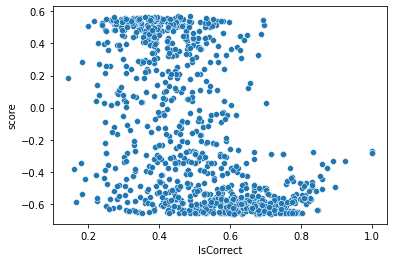

In [29]:
sns.scatterplot(x = 'IsCorrect' , y= 'score', data = final_data)

<AxesSubplot:xlabel='Confidence', ylabel='score'>

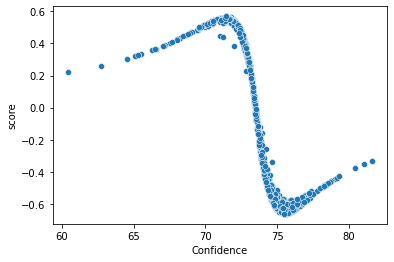

In [30]:
sns.scatterplot(x = 'Confidence' , y= 'score', data = final_data)

<AxesSubplot:xlabel='Age', ylabel='score'>

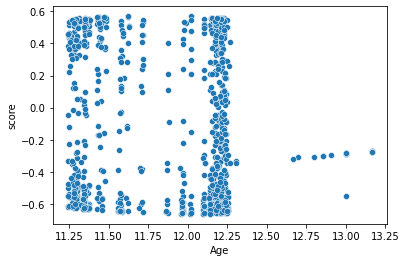

In [31]:
sns.scatterplot(x = 'Age' , y= 'score', data = final_data)

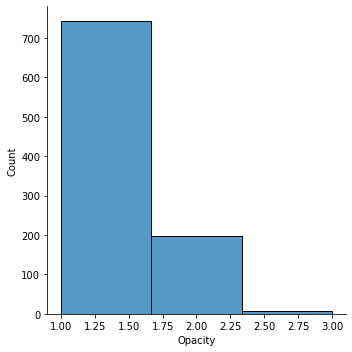

In [32]:
sns.displot(x= 'Opacity', data =  final_data, bins = 3)

<AxesSubplot:xlabel='Opacity', ylabel='score'>

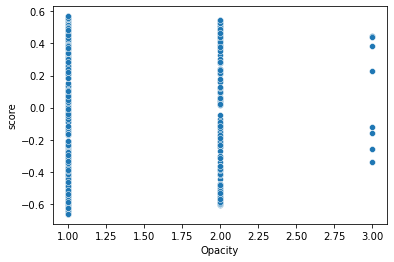

In [33]:
sns.scatterplot(x = 'Opacity' , y= 'score', data = final_data)

In [34]:
#*************************************************************************************************
#******************************extending & upgrading final project********************************
#*************************************************************************************************

from sklearn.decomposition import PCA

In [35]:
pca_final_data = None

def pca_process():
    pca_X = final_data_original.copy()
    global pca_final_data
    pca_final_data = final_data_original.copy()
    
    pca = PCA(n_components=2)
    pca_X = pca.fit_transform(pca_X)
    
    pca_kmeans = KMeans(n_clusters=2)
    pca_kmeans.fit(pca_X)
    
    pca_y_pred = pca_kmeans.predict(pca_X)
    
    pca_score_val = silhouette_samples(pca_X, pca_kmeans.labels_)
    pca_score_val[pca_y_pred == 1] = -pca_score_val[pca_y_pred == 1]
    
    pca_final_data = pca_final_data.drop(['IsCorrect', 'Confidence', 'Age', 'Opacity'], axis = 1)
    pca_final_data[['PCA1', 'PCA2']] = pca_X
    pca_final_data['score'] = pca_score_val
    
    pca_ranking = get_ranking(pca_final_data)
    
    pca_test = evaluation(final_test_raw, pca_ranking)
    pca_fin = evaluation(test_raw, pca_ranking, pca_test[1])
    
    del pca_X
    
    return (pca_test[0], pca_fin[0])


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

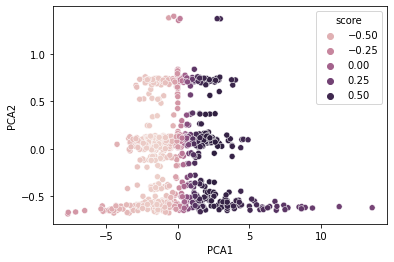

In [36]:
pca_process()
sns.scatterplot(data= pca_final_data, x='PCA1', y='PCA2', hue= 'score')

In [37]:
# select feature that gives the highest accuracy
# automate the process
def whole_process(flag):
    if flag <=0 or flag >= 16: return
    cols_pick = []
    if flag & 0b0001: cols_pick.append(0)
    if flag & 0b0010: cols_pick.append(1)
    if flag & 0b0100: cols_pick.append(2)
    if flag & 0b1000: cols_pick.append(3)
    X = final_data_original.copy().iloc[ : , cols_pick]
    data = final_data_original.copy()
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    
    score_val = silhouette_samples(X, kmeans.labels_)
    score_val[y_pred == 1] = -score_val[y_pred == 1]
    data['score'] = score_val
    ranking = get_ranking(data)
    
    tes = evaluation(test_raw, ranking)
    fin = evaluation(final_test_raw, ranking, tes[1])
    
    index = list(X.columns)
    
    del X, data, cols_pick
    return (index, tes[0], fin[0])

def select_features():
    x = []
    y1 = []
    y2 = []
    for i in range(1,16):
        a,b,c = whole_process(i)
        x.append(', '.join(str(s[0]) for s in a))
        y1.append(b)
        y2.append(c)
    return (x,y1,y2)

def with_PCA():
    idx, tes, fin_tes = select_features()
    idx.append('PCA')
    
    pca_test, pca_fin = pca_process()
    
    tes.append(pca_test)
    fin_tes.append(pca_fin)
    
    return(idx, tes, fin_tes)

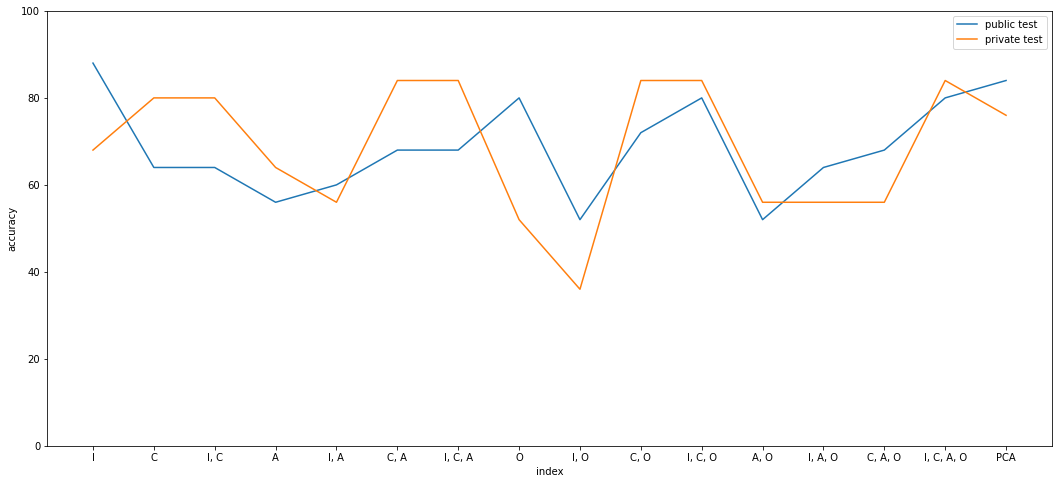

In [42]:
x, y1, y2 = with_PCA()
fig, ax = plt.subplots(figsize = (18,8))
ax.set_ylim([0,100])
ax.plot(x, y1, label = 'public test')
ax.plot(x, y2, label = 'private test')
ax.set_xlabel('index')
ax.set_ylabel('accuracy')

ax.legend()
plt.show()

#I = IsCorrect, A = Age, C = Confidence, O = Opacity